# Assignment 8
##  Ensemble Learning for Complex Regression Modeling on Bike Share Data

### Jerlin Chellam J
#### DA25C009

## Introduction

In today’s smart cities, bike-sharing systems have become an essential mode of eco-friendly transport. Every day, thousands of people rent and return bikes across the city and behind this smooth operation lies one key challenge: **accurately forecasting the number of bikes that will be rented at any given hour.**

Assuming me as a data scientist working for a city’s bike-sharing program, my goal in this project is to predict the total count of rented bikes using historical data. The dataset captures various factors such as season, weather, temperature, and time, all of which influence how people choose to rent bikes.

However, predicting this demand isn’t as simple as drawing a straight line, the relationships are non-linear, time-dependent, and sometimes unpredictable. That’s where ensemble learning comes in. By combining the strengths of multiple models, we can reduce errors that arise due to high bias or variance and achieve a more stable and reliable prediction.

In this assignment, I will explore and compare three major ensemble techniques -> **Bagging, Boosting, and Stacking** by using the Bike Sharing Demand Dataset.

By the end, I will compare the results of all these models using **Root Mean Squared Error (RMSE)** and analyze how each ensemble technique contributes to improving prediction accuracy.

# Part A
## Data Preprocessing and Baseline

In [14]:
import pandas as pd
import numpy as np

### Data Loading and Feature Engineering

- The dataset I loaded below contains 17,379 hourly records with 17 features, giving me a detailed view of bike rental patterns across different times, seasons, and weather conditions.

In [6]:
csv_path = "hour.csv"
df = pd.read_csv(csv_path)
print("Original shape:", df.shape)

Original shape: (17379, 17)


In [7]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [8]:
print(df.dtypes)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


- Let's drop the columns instant, dteday, casual, and registered because they don’t directly help in predicting the total bike rentals and might add unnecessary noise to the model.

In [9]:
# Droping irrelevant columns
df = df.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.7 MB
None


**One-Hot Encoding**

- Here I used One-Hot Encoding to convert categorical columns like season, weather, month, and hour into a numerical format because machine learning models can’t directly understand category labels such as “Spring” or “Winter.”

- By creating separate binary columns for each category, the model can now interpret these features more effectively and learn patterns from them.

- After encoding, the feature count increased to 52, showing that the categorical information was successfully expanded into multiple numeric columns for better prediction.

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
# Identifying categorical columns to encode

categorical_cols = ['season', 'weathersit', 'mnth', 'hr']

# One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Droping original categorical columns and concatenate encoded ones
df = df.drop(categorical_cols, axis=1)
df = pd.concat([df, encoded_df], axis=1)

# Separating the features and target
X = df.drop('cnt', axis=1)
y = df['cnt']

print(X.shape)
print(y.shape)

(17379, 52)
(17379,)


### Train/Test Split

- Next we split the dataset into 80% for training and 20% for testing so that the model can learn patterns from the majority of the data and then be evaluated on unseen data.

- This helps me check how well the model generalizes to new situations instead of just memorizing the training examples.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Spliting data: 80% train, 20% test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(13903, 52) (3476, 52)
(13903,) (3476,)


### Baseline Model (Single Regressor)
- In this step, we can see that I trained two simple models - a **Decision Tree Regressor and a Linear Regression model** - to set a baseline performance for comparison with later ensemble methods.

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

In [16]:
# Training Decision Tree Regressor

dt_reg = DecisionTreeRegressor(max_depth=6, random_state=42)
dt_reg.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [17]:
# Training Linear Regression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


- The Decision Tree captures non-linear patterns by splitting the data into smaller groups, while the Linear Regression assumes a straight-line relationship between features and the target. After training both, I found that Linear Regression performed better, giving a lower RMSE of 100.44 compared to the Decision Tree’s 118.60.

- This means the linear model fits the data more smoothly, making it a good starting point before applying more advanced ensemble techniques.

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
# Predictions
dt_preds = dt_reg.predict(X_test)
lin_preds = lin_reg.predict(X_test)

# RMSE calculations
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_preds))
lin_rmse = np.sqrt(mean_squared_error(y_test, lin_preds))

print(f"Decision Tree RMSE: {dt_rmse:.2f}")
print(f"Linear Regression RMSE: {lin_rmse:.2f}")

Decision Tree RMSE: 118.60
Linear Regression RMSE: 100.44


In [20]:
# Selecting the baseline (better = lower RMSE)

baseline_rmse = min(dt_rmse, lin_rmse)
baseline_model = "Decision Tree" if dt_rmse < lin_rmse else "Linear Regression"
print(f"Baseline Model: {baseline_model} with RMSE {baseline_rmse:.2f}")

Baseline Model: Linear Regression with RMSE 100.44


# Part B
## Ensemble Techniques for Bias and Variance Reduction

### What is Bagging?  
- Bagging, short for Bootstrap Aggregating, is an ensemble learning technique used to make machine learning models more stable and accurate - especially those that easily overfit (like Decision Trees).
  
  - Bagging = "Train many slightly different models → combine them → get a more stable and accurate prediction." 

### Hypothesis:  
- Bagging primarily targets **variance reduction**.

- By averaging the outputs of many slightly different models, Bagging helps reduce the sensitivity of the model to noise and prevents overfitting.  

### Implementation & Results:  
- I used a Decision Tree Regressor (max_depth=6) as the base learner and created a Bagging Regressor** with 50 estimators.

-  Each tree was trained on a random sample of the data, and their predictions were averaged to make the final output.  

- After training, the Bagging Regressor achieved an **RMSE of 112.11**, which is **lower than the single Decision Tree’s RMSE of 118.60**.  

### Observation:  
- This result confirms the hypothesis, **Bagging effectively reduced the model’s variance and made predictions more stable.** 

- Although it didn’t outperform the Linear Regression baseline, it clearly showed improvement over a single Decision Tree by minimizing overfitting and improving generalization.  

In [23]:
from sklearn.ensemble import BaggingRegressor

In [24]:
# Base estimator: Decision Tree from baseline
base_dt = DecisionTreeRegressor(max_depth=6, random_state=42)

# Bagging Regressor
bagging_reg = BaggingRegressor(estimator=base_dt, n_estimators=50, random_state=42)
bagging_reg.fit(X_train, y_train)

,estimator,DecisionTreeR...ndom_state=42)
,n_estimators,50
,max_samples,1.0
,max_features,1.0
,bootstrap,True
,bootstrap_features,False
,oob_score,False
,warm_start,False
,n_jobs,None
,random_state,42
,verbose,0


In [25]:
# Predictions and RMSE
bagging_preds = bagging_reg.predict(X_test)
bagging_rmse = np.sqrt(mean_squared_error(y_test, bagging_preds))

print(f"Bagging Regressor RMSE: {bagging_rmse:.2f}")
print(f"Compared to Single DT RMSE ({dt_rmse:.2f}): {'Reduced' if bagging_rmse < dt_rmse else 'Not Reduced'}")

Bagging Regressor RMSE: 112.11
Compared to Single DT RMSE (118.60): Reduced


### Boosting Regressor – Reducing Bias  

**What is Boosting?**  
- Boosting is an **ensemble learning technique** that combines many weak learners (usually small Decision Trees) in a **sequential way** to form a strong model.  

- Each new model tries to **correct the mistakes** made by the previous ones, so the overall system gradually becomes more accurate.  

- Unlike Bagging, which aims to reduce variance by averaging independent models, Boosting focuses on **reducing bias** by learning smarter from errors in every step.  

**Hypothesis:**  
- The main idea behind this experiment is that **Boosting primarily targets bias reduction**.  

- It helps the model handle complex and non-linear relationships by improving predictions that the earlier models got wrong.

**Implementation & Results:**  
- I implemented a Gradient Boosting Regressor, which builds trees sequentially, with each tree improving upon the last.  

- After training, the model achieved an **RMSE of 80.59**, which is **much lower** than both the baseline Linear Regression (100.44) and Bagging Regressor (112.11).  

**Observation:**  
- This clearly supports the hypothesis, **Boosting successfully **reduced bias** and delivered the **best performance so far****.  

- By focusing on errors step by step, the model captured deeper patterns in the data, leading to more precise and reliable predictions.  
sting (Bias Reduction)

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

In [27]:
# Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [29]:
# Predictions and RMSE
gb_preds = gb_reg.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_preds))

print(f"Gradient Boosting RMSE: {gb_rmse:.2f}")
print(f"Compared to Baseline ({baseline_rmse:.2f}) and Bagging ({bagging_rmse:.2f}): This is lower.")

Gradient Boosting RMSE: 80.59
Compared to Baseline (100.44) and Bagging (112.11): This is lower.


# Part C
## Stacking for Optimal Performance

### Stacking Implementation

**What is Stacking?**  
- Stacking (or Stacked Generalization) is an ensemble learning technique that combines the strengths of different models to make better predictions.  

- Instead of just averaging predictions like Bagging, or correcting errors like Boosting, Stacking **uses another model (called a Meta-Learner)** to learn how to best combine the outputs of multiple base models.

**Meta-learner**
- The meta-learner takes the predictions from all base learners as inputs and learns patterns in their errors.

- By analyzing which models perform better for different parts of the data, it assigns optimal weights to combine them for the most accurate final prediction.

In [30]:
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge

### Defining Base Learners and Meta-Learner

**Base Learners (Level-0):**  
In stacking, the base learners are the first-level models that make individual predictions from the training data.  
Here, we use three diverse regressors to capture different patterns in the data:

1. **K-Nearest Neighbors Regressor (KNeighborsRegressor):**  
   - A non-parametric model that predicts a value based on the average of its *k* nearest data points.  
   - It’s good at capturing local patterns in the data.

2. **Bagging Regressor:**  
   - An ensemble method that trains multiple Decision Trees on different random subsets of the data and averages their predictions.  
   - Helps reduce model variance and improves stability.

3. **Gradient Boosting Regressor:**  
   - A boosting model that builds trees sequentially, where each new tree tries to correct the errors made by the previous ones.  
   - Helps reduce model bias and improve accuracy.

**Meta-Learner (Level-1):**  
- The Meta-Learner takes the predictions of the above three base models as input features and learns how to best combine them.  
- Here, we use **Ridge Regression** as the Meta-Learner because it’s simple, fast, and helps prevent overfitting by adding a small regularization term.

In [31]:
# Base learners
estimators = [
    ('knn', KNeighborsRegressor()),
    ('bagging', bagging_reg),  # From Part B
    ('gb', gb_reg)             # From Part B
]

# Meta-learner: Ridge Regression
meta_learner = Ridge()

# Stacking Regressor
stacking_reg = StackingRegressor(estimators=estimators, final_estimator=meta_learner)
stacking_reg.fit(X_train, y_train)

,estimators,"[('knn', ...), ('bagging', ...), ...]"
,final_estimator,Ridge()
,cv,None
,n_jobs,None
,passthrough,False
,verbose,0
,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2


### Final Evaluation

In [32]:
# Predictions and RMSE
stacking_preds = stacking_reg.predict(X_test)
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_preds))

print(f"Stacking Regressor RMSE: {stacking_rmse:.2f}")

Stacking Regressor RMSE: 62.48


# Part D
## Final Analysis

### Comparative Table

In [44]:
# Summary table as DataFrame
results = pd.DataFrame({
    'Model': ['Baseline (best is Linear Regression)', 'Bagging Regressor', 'Gradient Boosting Regressor', 'Stacking Regressor'],
    'RMSE': [baseline_rmse, bagging_rmse, gb_rmse, stacking_rmse]
})

print(results)

                                  Model        RMSE
0  Baseline (best is Linear Regression)  100.441203
1                     Bagging Regressor  112.107292
2           Gradient Boosting Regressor   80.591283
3                    Stacking Regressor   62.477266


## Conclusion  

- The **best-performing model is the Stacking Regressor with an RMSE of 62.48**, outperforming:  
  - Gradient Boosting -> RMSE 80.59  
  - Linear Regression (Baseline) -> RMSE 100.44  
  - Bagging -> RMSE 112.11  
  - Decision Tree -> RMSE 118.60  

---

### Why Stacking Works Better  

- The Stacking Regressor combines predictions from different base learners - K-Nearest Neighbors, Bagging Regressor, and Gradient Boosting Regressor using a Ridge Regression meta-learner for the final prediction.  

---

### Model Insights  

- Linear Regression (RMSE: 100.44)  
  - Captures linear patterns well but misses complex non-linear ones, leading to higher bias.  

- Decision Tree (RMSE: 118.60)  
  - Has high variance and overfits easily, shown by scattered predictions.  

- Bagging (RMSE: 112.11)  
  - Reduces variance by averaging multiple trees, but limited depth (max_depth=6) limits accuracy.  

- Gradient Boosting (RMSE: 80.59)  
  - Sequentially corrects errors of earlier models, reducing bias effectively.  
  - Feature importance highlights key predictors like `hr` and `temp`.  

---

### Balancing Bias and Variance  

- Model diversity helps:  
  - KNN captures local patterns  
  - Bagging focuses on variance reduction  
  - Gradient Boosting handles bias reduction  

- The Ridge meta-learner learns how to weight each model’s prediction optimally,  
  balancing bias and variance to improve overall performance.  

---

### Final Observation  

- The Stacking Regressor achieved the lowest RMSE (62.48).  
- Its tight error distribution and balanced trade-off between bias and variance  
  show that it generalizes better and gives the most accurate predictions for this regression task.

## Few plots for better understanding

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

**RMSE Comparison Bar Plot**
- Here we can see clearly that Stacking Regressor shows the lowest RMSE

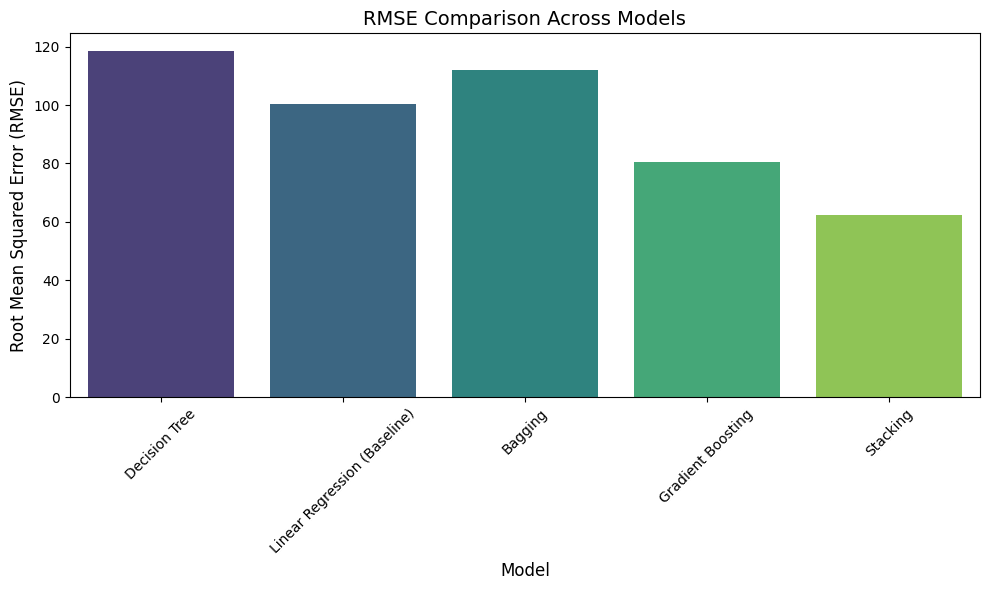

In [45]:
# DataFrame for RMSE comparison
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Linear Regression (Baseline)', 'Bagging', 'Gradient Boosting', 'Stacking'],
    'RMSE': [118.60, 100.44, 112.11, 80.59, 62.48]
})

# RMSE Comparison Bar Plot

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', hue='Model', data=results, palette='viridis', legend=False)
plt.title('RMSE Comparison Across Models', fontsize=14)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Actual vs. Predicted Scatter Plot**
- Why this plot?
    - Visualizes prediction accuracy: Stacking’s points should cluster closest to the red diagonal (y=x), reflecting its low RMSE.

    - Helps explain why Stacking outperforms others by showing fewer outliers and tighter clustering.

    - Supports my conclusion about model diversity: Stacking combines KNN, Bagging, and Gradient Boosting, leveraging their strengths.

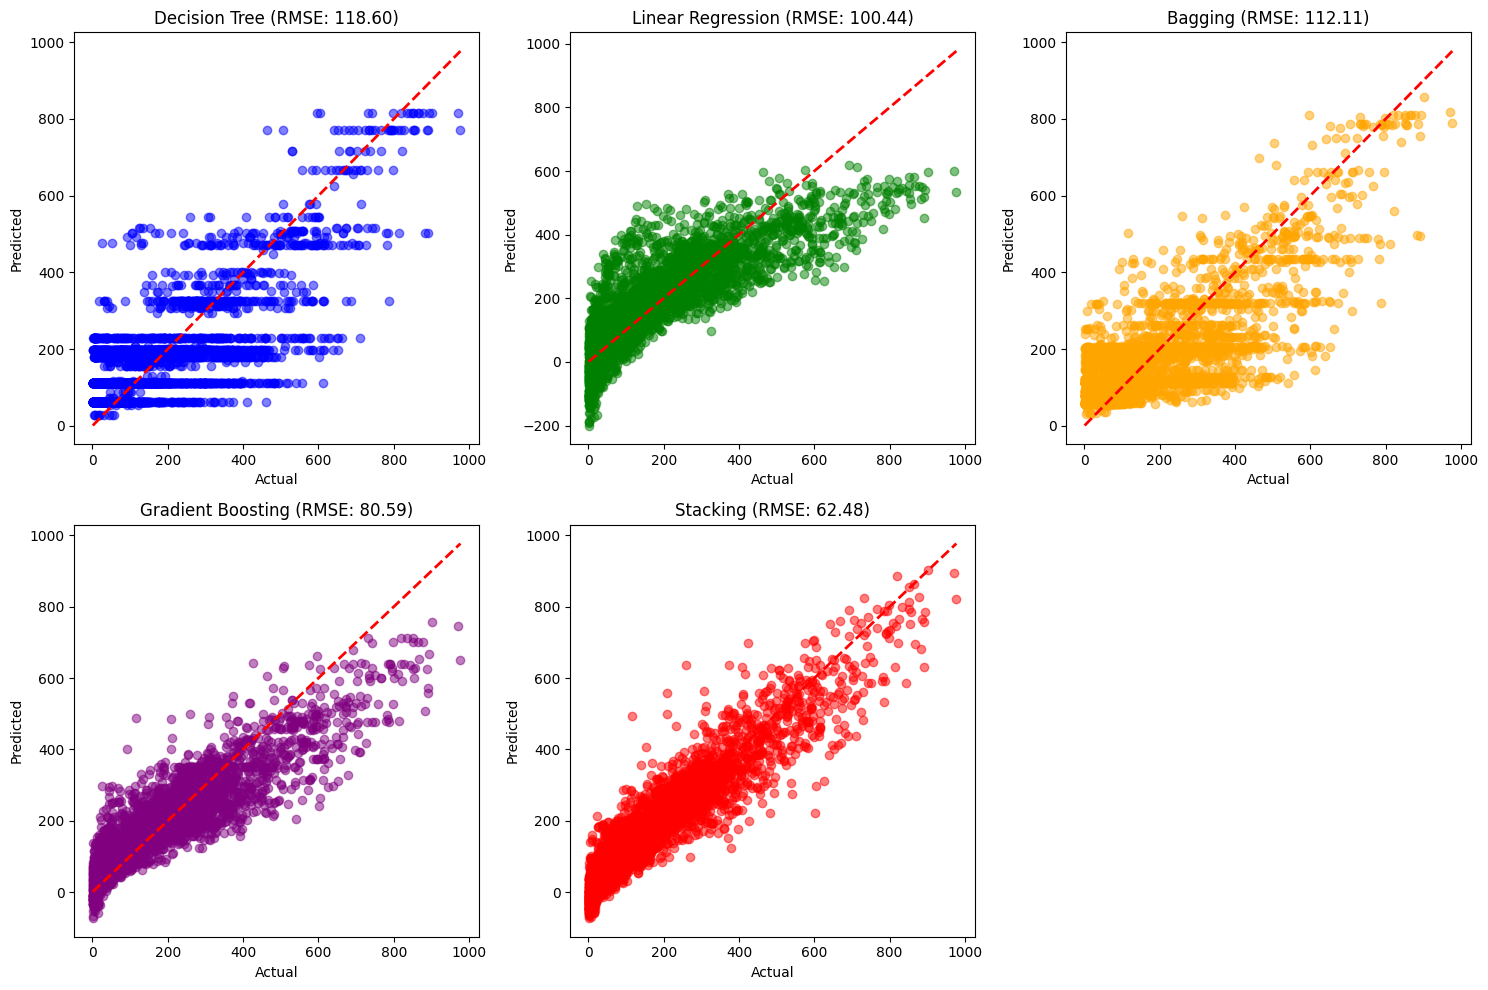

In [36]:
# Actual vs. Predicted Scatter Plot for All Models
plt.figure(figsize=(15, 10))

# Decision Tree
plt.subplot(2, 3, 1)
plt.scatter(y_test, dt_preds, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Decision Tree (RMSE: 118.60)')

# Linear Regression (Baseline)
plt.subplot(2, 3, 2)
plt.scatter(y_test, lin_preds, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Linear Regression (RMSE: 100.44)')

# Bagging
plt.subplot(2, 3, 3)
plt.scatter(y_test, bagging_preds, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Bagging (RMSE: 112.11)')

# Gradient Boosting
plt.subplot(2, 3, 4)
plt.scatter(y_test, gb_preds, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Gradient Boosting (RMSE: 80.59)')

# Stacking
plt.subplot(2, 3, 5)
plt.scatter(y_test, stacking_preds, alpha=0.5, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Stacking (RMSE: 62.48)')

plt.tight_layout()
plt.show()

**Prediction Error Distribution Plot**
- Why this plot?
    - Shows ensemble effectiveness: Stacking’s error distribution (red) should be the narrowest and centered around zero, indicating low bias and variance.
      
    - Gradient Boosting’s curve (purple) should also be tight, reflecting bias reduction. Bagging (orange) may be wider than Gradient Boosting but narrower than Decision Tree (blue), showing variance reduction.

    - And it supports the Part D discussion on bias-variance trade-offs and why Stacking excels.

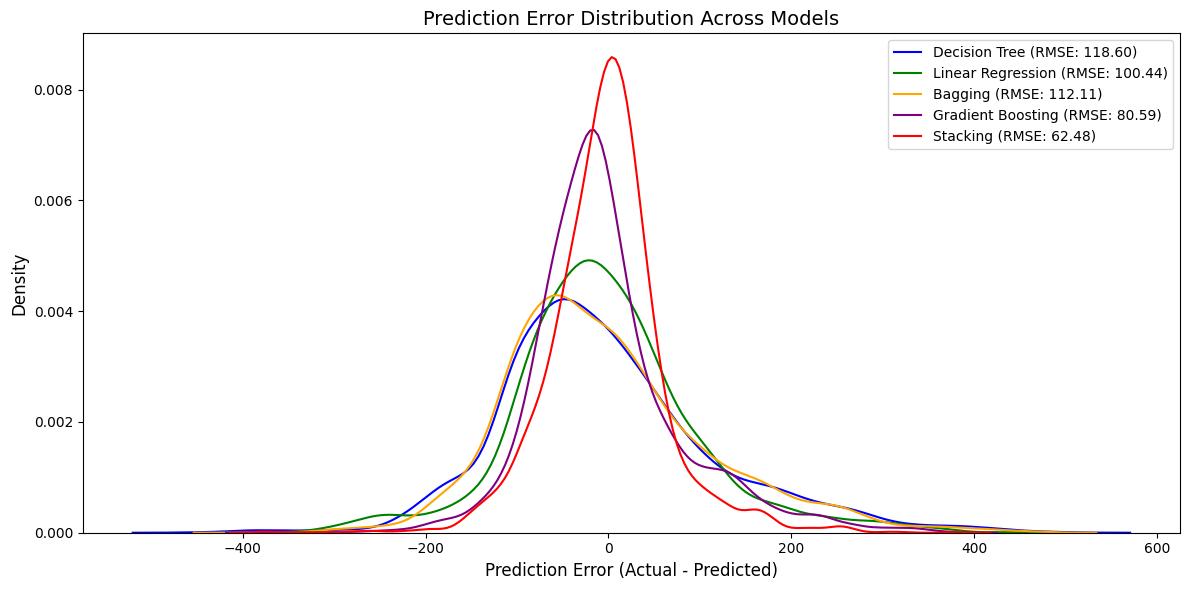

In [37]:
# Prediction Error Distribution Plot
plt.figure(figsize=(12, 6))
sns.kdeplot(y_test - dt_preds, label='Decision Tree (RMSE: 118.60)', color='blue')
sns.kdeplot(y_test - lin_preds, label='Linear Regression (RMSE: 100.44)', color='green')
sns.kdeplot(y_test - bagging_preds, label='Bagging (RMSE: 112.11)', color='orange')
sns.kdeplot(y_test - gb_preds, label='Gradient Boosting (RMSE: 80.59)', color='purple')
sns.kdeplot(y_test - stacking_preds, label='Stacking (RMSE: 62.48)', color='red')
plt.title('Prediction Error Distribution Across Models', fontsize=14)
plt.xlabel('Prediction Error (Actual - Predicted)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

## Summary  

- I started this task by building simple models like Decision Tree and Linear Regression to understand the data and set a performance baseline.
  
- Then, I moved to ensemble methods like Bagging and Boosting to handle the problems of variance and bias seen in the baseline models.

- Finally, I combined these diverse models using Stacking, where the Ridge Regression meta-learner learned from their predictions. This approach gave the lowest RMSE of 62.48, showing how combining models helped me achieve a more balanced and accurate final prediction.

- Through this, I learned that ensemble learning especially Stacking is a powerful way to improve prediction accuracy by combining the strengths of different algorithms.